<a href="https://colab.research.google.com/github/Yuma-Ichikawa/pytorch/blob/master/dataset_dataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PytorchのDatasetとDataLoader

深層学習の場合、データが大きくなるとデータの一部を利用してパラメータを更新するミニバッチ勾配降下法という手法を使います。

PyTorchには、便利なことにミニバッチ学習をサポートするDataset、DataLoaderというツールがあります。

基本的な使い方は、特徴量行列XとラベルYをDatasetに渡し、一つのデータベース的なものを作成します。

その後、DatasetをDataLoaderに渡すことで、ミニバッチを生成するイテラブルを作成することができます。

DataLoaderは配列ではなくIteratorを返す

trainloaderはiteratorなので、呼び出したdataは全データを見切るまで２度と見れなくなってしまう。

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorchのデータセットを使用する方法

- root : データセットを保存するディレクトリ
- train : Trueとすると訓練データ、Falseとするとテストデータ
- download : Trueとするとデータをダウンロードしてrootで指定したディレクトリに保存
- transform : 画像データを使用するは、前処理を指定する

In [3]:
MNIST = torchvision.datasets.MNIST(root='./data',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(MNIST)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [16]:
DataLoader = torch.utils.data.DataLoader(dataset=MNIST,
                                           batch_size=100,
                                           shuffle=True)

## Pandas or Numpyのデータを使用する

#### まずは、Numpyデータの使用方法

一番簡単な方法は、Tensorに直接変換してデータセット型に変形する

注意しなくてはならないのは、Pytorchを使用する場合

- float64 → float32
- int64 → int64

In [2]:
from sklearn.datasets import load_digits
digits=load_digits()

In [3]:
X = digits.data
y = digits.target

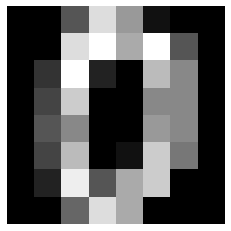

In [14]:
# 特徴量
fig, ax = plt.subplots()
ax.imshow(X[0].reshape(8,8), cmap='gray')
ax.axis('off')
plt.show()

In [6]:
y[0]

0

In [15]:
# Tensorに変更
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64) 

# 下記を使用しても良い
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

# Datasetを作成
Dataset = torch.utils.data.TensorDataset(X, y)

# DataLoaderを作成
DataLoader = torch.utils.data.DataLoader(Dataset, batch_size=100, shuffle=True)

In [16]:
print(Dataset)

In [17]:
import seaborn as sns
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [18]:
# カテゴリ変数を変換
iris.loc[:, 'species'] = iris.loc[:, 'species'].map({'setosa':0, 'versicolor':1, 'virginica':2})
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [81]:
len(iris)

150

In [29]:
# valueでnumpy配列として取り出せる
y = torch.FloatTensor(iris['species'].values)
X = torch.LongTensor(iris.drop('species', axis=1).values)

# Datasetを作成
Dataset = torch.utils.data.TensorDataset(X, y)

# DataLoaderを作成
DataLoader = torch.utils.data.DataLoader(Dataset, batch_size=100, shuffle=True)

In [40]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

### 自分の持っているデータセットを読み込む

自分の持っているデータセットを読み込むためには、Datasetクラスを継承する必要があります。

## 少し高度なDataFrameの作成方法

In [25]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.LongTensor(self.labels[idx])
        return features_x, labels

In [26]:
# 特徴量の名前
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# ラベルの名前
label = ['species']

Dataset = MyDataset(iris, features, label)

In [27]:
# lenを使用する
len(Dataset)

150

In [34]:
# 要素を参照する
Dataset[0]

(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor([0]))

In [30]:
Dataloader = torch.utils.data.DataLoader(Dataset, batch_size=20, shuffle=True)

In [31]:
for x, y in Dataloader:
    x = x
    y = y

In [33]:
y

tensor([[0],
        [1],
        [2],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0]])

前処理を設定できる

In [36]:
# 自作transformer
class Square(object):
    def __init__(self):
        pass
    def __call__(self, x):
        x = x**2 
        return x

In [35]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels, transform=None):
        self.features_values = df[features].values
        self.labels = df[labels].values
        self.transform = transformer

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.LongTensor(self.labels[idx])

        # 前処理を施す
        if self.transform:
            features_x = self.transform(features_x)
        
        return features_x, labels

In [37]:
# 特徴量の名前
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# ラベルの名前
label = ['species']

# transformer(Square)のインスタン化
transformer = Square()

Dataset = MyDataset(iris, features, label, transform=transformer)

In [38]:
Dataset[0]

(tensor([26.0100, 12.2500,  1.9600,  0.0400]), tensor([0]))

In [66]:
class MyDataset(Dataset):
    def __init__(self, df, number_features, category_features, labels):
        self.number_values = df[number_features].values
        self.category_values = df[category_features].values
        self.labels = labels
    def __len__(self):
        return len(self.number_values)
    def __getitem__(self, idx):
        number_x = torch.FloatTensor(self.number_values[idx])
        category_x = torch.LongTensor(self.category_values[idx])
        # labelの種類による
        labels = torch.LongTensor(self.labels)
        return number_x, category_x, labels

In [67]:
number_features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
category_features = []
lable = iris['species']

In [68]:
Dataset = MyDataset(iris, number_features, category_features, lable)

In [69]:
train_loader = DataLoader(Dataset, batch_size=100, shuffle=True)

## 画像データの場合

PIL image, ndarrayをCahnnel Height Widthに変換する

1. transformsの定義(先頭から順に実行する）
2. Datasetsによる前処理
3. DataloaderによるDatasetの使用